In [78]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
from lightgbm import plot_tree
from graphviz import Digraph
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold,GroupKFold
from sklearn.metrics import roc_auc_score
import time
import pickle

%matplotlib inline

# Load Original Features

In [2]:
feat_num = 445

In [147]:
#df_total_raw = pd.read_csv('./data/features%s.csv'%(feat_num))
#with open('./data/features%s.pickle'%(feat_num), 'rb') as handle:
with open('./data/EDA/train_df.pkl', 'rb') as handle:
    df_total_raw = pickle.load(handle)

In [157]:
#to_drop = ['V'+str(i) for i in range(1,340)]
with open('./data/EDA/remove_features.pkl', 'rb') as handle:
#with open('./data/feat%s_rm_pm_importance100.pickle'%(437), 'rb') as handle:
    to_drop = pickle.load(handle).features_to_remove
    to_drop = list(set(to_drop) - set(['isFraud','TransactionID']))

In [158]:
with open('./data/feat%s_rm_pm_importance100.pickle'%(437), 'rb') as handle:
    to_drop_ori = pickle.load(handle)
    to_drop_ori = list(set(to_drop_ori) - set(['screen_height']))

In [159]:
to_drop = set(to_drop) | set(to_drop_ori)

In [161]:
df_total = df_total_raw.drop(list(to_drop),axis=1)
#df_total = df_total_raw

In [162]:
with open('./data/EDA/test_df.pkl', 'rb') as handle:
    features_test_raw = pickle.load(handle)

In [163]:
features_train = df_total[df_total['isFraud'].notnull()]
#features_test = df_total[df_total['isFraud'].isnull()]
features_test = features_test_raw.drop(list(to_drop),axis=1)

In [164]:
labels_train = features_train['isFraud']
features_train = features_train.drop(columns = ['isFraud', 'TransactionID'])

In [165]:
print(features_train.shape)
print(features_test.shape)

(590540, 673)
(506691, 675)


# Prepare model

In [166]:
categorical = ['ProductCD', 'card2', 'card3', 'card4', 'card5','card6',
              'addr1','addr2','P_email','R_email','M1','M2','M3',
              'M4','M5','M6','M7','M8','M9','DeviceType','DeviceInfo','dow','hour',
              'Device_name','Device_version','screen_width','screen_height',
               'P_email_suffix','R_email_suffix','id_30_OS','id_30_version',
              'is_card_freq_Device','is_wide','is_long','is_zero','is_win8_vista',
              'is_windows_otheros','is_card_freq_pdc','is_card_freq_addr1'] 
ids = [ 'id_%s'%(i) for i in range(12,39)]
categorical = categorical + ids

In [167]:
categorical = list(set(categorical).intersection(df_total.columns))

In [168]:
features_test_new = features_test.drop(columns = ['isFraud', 'TransactionID'])

In [106]:
params1 = {'objective':'binary',
          'boosting_type':'gbdt',
          'metric':'auc',
          'learning_rate':0.006,
          'num_leaves': 2**8,
          'max_depth':-1,
          'colsample_bytree':0.5,# feature_fraction 0.7
          'subsample_freq':1,
          'subsample':0.7,
          'verbose':-1,
          'seed': 47,#42
          'ignore_column':['DT_month']#47,
                } 

In [169]:
params = {'objective': 'binary',# Core Parameters
          "boosting_type":"gbdt",#'goss' # Core Parameters
          "metric": 'auc',
          'learning_rate': 0.006883242363721497,
          'num_leaves': 491,# This is the main parameter to control the complexity of the tree model
          'max_depth': -1,# You also can use max_depth to limit the tree depth explicitly.
          'min_data_in_leaf': 106,# This is a very important parameter to prevent over-fitting in a leaf-wise tree. 
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'feature_fraction_seed':11,
          'bagging_fraction': 0.4181193142567742,#randomly select part of data without resampling #control overfitting
          "bagging_seed": 11,
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,#L1
          'reg_lambda': 0.6485237330340494,#L2
          'random_state': 47
          #'num_threads':10
          #'device' :'gpu',
          #'is_unbalance':True
          #'scale_pos_weight':9
         }

# Feature Selection

In [170]:
features_train.tail()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_38,DeviceType,DeviceInfo,id_33_0,id_33_1,DeviceInfo_device,DeviceInfo_version,id_30_device,id_30_version,id_31_device
590535,3.912023,0.020399,6550.0,NaN,150.0,719649.0,226.0,824959.0,272.0,87.0,...,NaN,2,811091,NaN,NaN,811091,811091,811091,811091,811091
590536,3.701302,0.020399,10444.0,225.0,150.0,347386.0,224.0,824959.0,204.0,87.0,...,NaN,2,811091,NaN,NaN,811091,811091,811091,811091,811091
590537,3.464270,0.020399,12037.0,595.0,150.0,347386.0,224.0,824959.0,231.0,87.0,...,NaN,2,811091,NaN,NaN,811091,811091,811091,811091,811091
590538,4.770685,0.020399,7826.0,481.0,150.0,347386.0,224.0,824959.0,387.0,87.0,...,NaN,2,811091,NaN,NaN,811091,811091,811091,811091,811091
590539,5.638355,0.020399,15066.0,170.0,150.0,347386.0,102.0,267648.0,299.0,87.0,...,NaN,2,811091,NaN,NaN,811091,811091,811091,811091,811091


In [171]:
features_train['pdf_Amt_ratio'] = features_train['TransactionAmt']/features_train.groupby('ProductCD')['TransactionAmt'].transform('mean')
features_test['pdf_Amt_ratio'] = features_test['TransactionAmt']/features_test.groupby('ProductCD')['TransactionAmt'].transform('mean')


In [172]:
features_train.shape

(590540, 674)

In [ ]:
start = time.time()
vaild_num = int(features_train.shape[0]*0.8)#472432
train_set = lgb.Dataset(features_train.iloc[0:vaild_num,:], label=labels_train.values[0:vaild_num],categorical_feature=categorical)#
valid_set = lgb.Dataset(features_train.iloc[vaild_num:,:], label=labels_train.values[vaild_num:],categorical_feature=categorical)#
valid_results = {}
model = lgb.train(params,train_set,num_boost_round = 10000, 
                  valid_sets = [train_set, valid_set],
                  verbose_eval=500,
                  early_stopping_rounds = 500,
                  evals_result=valid_results)
print(time.time()-start)

/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.


In [51]:
max(valid_results['valid_1']['auc'])

0.9324208392017403

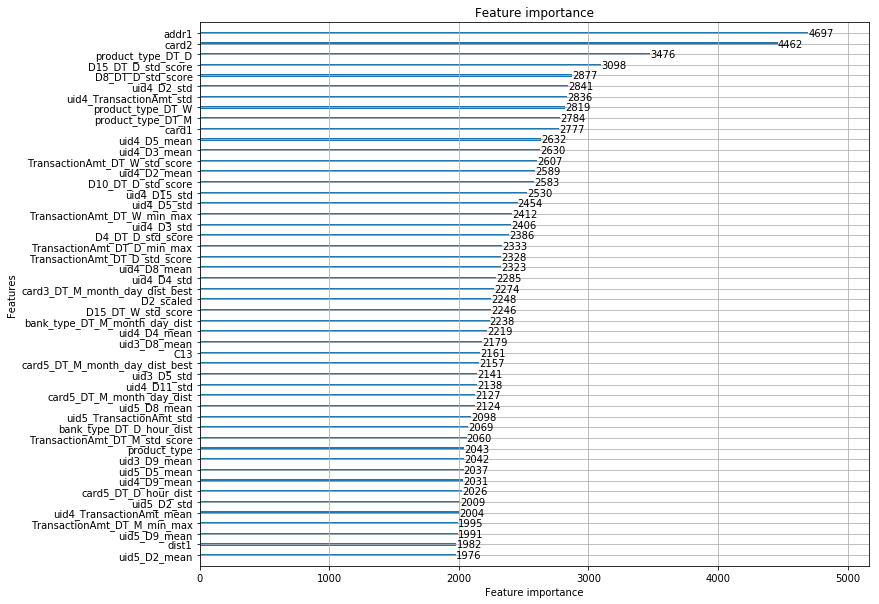

In [52]:
lgb.plot_importance(model, max_num_features=50,figsize=(12,10))
#lgb.plot_split_value_histogram(model, feature='dist1', bins='auto')
#lgb.plot_metric(valid_results, metric='auc')

In [ ]:
lgb.plot_tree(model,tree_index=0, figsize=(107,105))
graph = lgb.create_tree_digraph(model, tree_index=0, name='Tree0')
graph.render(view=True)

# Train Model

In [173]:
def fold_train_model(splits_num,features_train,labels_train,categorical):
    splits = splits_num
    folds = KFold(n_splits = splits,random_state=50)
    predictions = np.zeros(len(features_test_new))
    ave_auc = 0
    
    for fold_num, (trn_idx, val_idx) in enumerate(folds.split(features_train.values, 
                                                          labels_train.values)):
        print("Fold {}".format(fold_num))
        train_df, y_train_df = features_train.iloc[trn_idx], labels_train.iloc[trn_idx]
        valid_df, y_valid_df = features_train.iloc[val_idx], labels_train.iloc[val_idx]

        trn_data = lgb.Dataset(train_df, label=y_train_df,categorical_feature=categorical)
        val_data = lgb.Dataset(valid_df, label=y_valid_df,categorical_feature=categorical)

        valid_results = {}
        clf = lgb.train(params,
                        trn_data,
                        10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds=500,
                        evals_result=valid_results)

        pred = clf.predict(valid_df)
        auc_score = roc_auc_score(y_valid_df, pred)
        ave_auc += auc_score / splits
        predictions += clf.predict(features_test_new) / splits
    return ave_auc,predictions

In [98]:
def group_fold_train_model(splits_num,features_train,labels_train,categorical):
    splits = splits_num
    predictions = np.zeros(len(features_test_new))
    ave_auc = 0
    
    folds = GroupKFold(n_splits=splits)
    split_groups = features_train['DT_month']
    
    for fold_num, (trn_idx, val_idx) in enumerate(folds.split(features_train.values, 
                                                              labels_train.values,groups=split_groups)):
        print("Fold {}".format(fold_num))
        train_df, y_train_df = features_train.iloc[trn_idx], labels_train.iloc[trn_idx]
        valid_df, y_valid_df = features_train.iloc[val_idx], labels_train.iloc[val_idx]

        trn_data = lgb.Dataset(train_df, label=y_train_df,categorical_feature=categorical)
        val_data = lgb.Dataset(valid_df, label=y_valid_df,categorical_feature=categorical)

        valid_results = {}
        clf = lgb.train(params,
                        trn_data,
                        10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds=500,
                       evals_result=valid_results)

        pred = clf.predict(valid_df)
        auc_score = roc_auc_score(y_valid_df, pred)
        ave_auc += auc_score / splits
        predictions += clf.predict(features_test_new) / splits
    return ave_auc,predictions
    

In [ ]:
ave_auc,predictions = group_fold_train_model(5,features_train,labels_train,categorical)

In [ ]:
ave_auc,predictions = fold_train_model(6,features_train,labels_train,categorical)

Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.995537	valid_1's auc: 0.923139
[1000]	training's auc: 0.999886	valid_1's auc: 0.931515
[1500]	training's auc: 0.999999	valid_1's auc: 0.933231
[2000]	training's auc: 1	valid_1's auc: 0.933808
[2500]	training's auc: 1	valid_1's auc: 0.933937
Early stopping, best iteration is:
[2139]	training's auc: 1	valid_1's auc: 0.933878
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.995621	valid_1's auc: 0.93674
[1000]	training's auc: 0.999905	valid_1's auc: 0.944471
[1500]	training's auc: 0.999999	valid_1's auc: 0.945621


In [175]:
ave_auc

0.9456485302824892

In [124]:
#feat773 6fold old param
ave_auc

0.9454123578537216

In [117]:
#feat772 old param
ave_auc

0.9452609251803124

In [110]:
# feat 772 compelet data new param 6 fold
ave_auc

0.9436339201979236

In [105]:
# feat 772 compelet data new param
ave_auc

0.9364594184747758

In [96]:
# feat 772 compelet data old param
ave_auc

0.9375409531738381

In [75]:
# feat 772 not compelet data 
ave_auc

0.9416703150283735

In [66]:
# feat440 old param not delete 100 feature
ave_auc

0.9378679394828393

In [25]:
# feat440 new param 6 fold
ave_auc

0.9396926157221407

In [17]:
# feat440 new param 5 fold
ave_auc

0.9364543671827509

In [34]:
# feat440 add card_DeviceType_fq
ave_auc

0.9383068452162177

In [18]:
# feat439 na -999
ave_auc

0.9381576015559274

In [25]:
# feat439 num of leave 300
ave_auc

0.9368800258774106

In [16]:
# feat439 lr 0.005
ave_auc

0.9378605282673502

In [206]:
#feat439 6 fold
ave_auc

0.9423037793396379

In [174]:
# feat440 add id_31_fq_enc
ave_auc

0.9381709259349416

In [159]:
# feat440 add id_30_fq_enc
ave_auc

0.9380367451399003

In [128]:
# feat439 change device info
ave_auc

0.9380337132311257

In [112]:
# feat439 add card_mv_day_fq
ave_auc

0.9382558553226678

In [97]:
# feat441 drop card4_fraud_rate and pemail fraud rate
ave_auc

0.9378070966039451

In [73]:
# feat441 drop feat437_rm_pm_importance100 drop hour amt and card4_fraud_rate
ave_auc

0.9375985902362556

In [61]:
# feat441 drop feat437_rm_pm_importance100 drop hour amt
ave_auc

0.9375681374967423

In [46]:
# feat441 drop feat437_rm_pm_importance100 
ave_auc

0.9375681381106405

In [17]:
# feat438 add addr1 cnt drop feat437_rm_pm_importance100
ave_auc

0.9378057475398072

In [34]:
# feat437 add card1 cnt drop feat437_rm_pm_importance100
ave_auc

0.9372995256863785

In [17]:
# feat437 add card1 cnt drop transactionDT
ave_auc

0.9347757078114228

In [68]:
# feat437 add card1 cnt
ave_auc

0.9371691266159269

In [33]:
# feat436 add pdc amt ratio
ave_auc

0.9360835858343227

In [31]:
# feat457 drop Vfeature
ave_auc

0.9320555176749314

In [16]:
# feat 457 drop c8
ave_auc

0.9354828335082059

In [19]:
# feat 457 all features
ave_auc

0.9352800271384787

In [77]:
submission.shape

(89326, 2)

In [176]:
id_test = features_test['TransactionID']
submission = pd.DataFrame({'TransactionID': id_test, 
                            'isFraud': predictions})
submission.to_csv('./data/sub_feat%s_%s.csv'%(673,'old_param_6fold'), index = False)
#submission.to_csv('./data/sub_feat%s_drop100.csv'%(feat_num), index = False)


# Recursive Test

In [15]:
features_train.iloc[:,-20:-1].head()

,id_32,id_34,id_35,id_36,id_38,DeviceType,DeviceInfo,P_email,R_email,screen_width,pdc_amt_ratio,card1_fq_enc,addr1_fq_enc,card_mv_day_fq,card_DeviceType_fq,is_December,card_id_fq_enc,card_D15_mean,DeviceType_DeviceInfo_fq
0,NaN,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.445929,56,43035.0,1,NaN,True,1,NaN,NaN
1,NaN,-1,-1,-1,-1,-1,-1,0,-1,-1,0.188788,1338,76902.0,1,NaN,True,3,0.000000,NaN
2,NaN,-1,-1,-1,-1,-1,-1,1,-1,-1,0.384085,1794,48387.0,1,NaN,True,13,1.982091,NaN
3,NaN,-1,-1,-1,-1,-1,-1,2,-1,-1,0.325496,7635,17455.0,11,NaN,True,84,0.761493,NaN
4,32.0,0,0,0,0,0,0,0,-1,0,0.686003,30,7107.0,1,1.0,True,1,NaN,9.0


In [ ]:
to_drop = {'is_December','card_id_fq_enc','card_D15_mean',
          'DeviceType_DeviceInfo_fq'}

test = ['is_December','DeviceType_screen_width_fq']
result = []
for col in to_drop:
    print(col)
    to_drop_temp = list(to_drop - set([col]))
    features_train_temp = features_train.drop(to_drop_temp,axis=1)
    print(features_train_temp.shape)
    categorical_temp = list(set(categorical).intersection(features_train_temp.columns))
    ave_auc,predictions = fold_train_model(5,features_train_temp,labels_train,categorical_temp)
    print(ave_auc)
    id_test = features_test['TransactionID']
    submission = pd.DataFrame({'TransactionID': id_test, 
                            'isFraud': predictions})
    submission.to_csv('./data/sub_feat%s_drop100_%s_test.csv'%(feat_num,col), index = False)
    result.append([col,ave_auc])

In [19]:
result

[['card_D15_mean', 0.9374476913201623],
 ['card_id_fq_enc', 0.937697053025252],
 ['is_December', 0.9377961755974762],
 ['DeviceType_DeviceInfo_fq', 0.9375744470481407]]

In [52]:
result

[['pdc_hour_Amt_mean', 0.9380002088591793],
 ['pdc_month_Amt_ratio', 0.9380738534486257],
 ['addr_Amt_ratio', 0.9381503901533759],
 ['pdc_hour_Amt_ratio', 0.9378806075783767],
 ['pdc_addr_Amt_ratio', 0.9381000559605122],
 ['dev_Amt_ratio', 0.9383520940351144],
 ['card_id_31_fq', 0.9380337093537161],
 ['card_id_30_fq', 0.9380861626171006],
 ['pdc_month_Amt_mean', 0.9384083713725051]]

In [17]:
result

[['card_DeviceInfo_fq', 0.938143843412518],
 ['card_DeviceType_fq', 0.9383068452162177],
 ['card_screen_width_fq', 0.9381135438426036]]

In [191]:
#'DT_hour_Amt_ratio','DT_day_Amt_ratio','DT_month_Amt_ratio',
#           'DT_year_Amt_ratio','card2_Amt_ratio',
#          'card3_Amt_ratio','card4_Amt_ratio','card5_Amt_ratio','card6_Amt_ratio'
result

[['card5_Amt_ratio', 0.9378145865335745],
 ['DT_day_Amt_ratio', 0.9378640126104663],
 ['card4_Amt_ratio', 0.937709725015683],
 ['card2_Amt_ratio', 0.937458223863788],
 ['DT_month_Amt_ratio', 0.9377889434647904],
 ['card6_Amt_ratio', 0.937863676290689],
 ['DT_hour_Amt_ratio', 0.9377024436406989],
 ['card3_Amt_ratio', 0.9376937326146639],
 ['DT_year_Amt_ratio', 0.9379433974493159]]